# 🧠 Stroke Detection – Jupyter (25 Epochs, No Data Generator)

In [2]:
# ✅ STEP 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [3]:
# ✅ STEP 2: Dataset paths
normal_path = r"C:\Users\fatim\OneDrive - IMAM ABDULRAHMAN BIN FAISAL UNIVERSITY\DataPerCut\Normal"
stroke_path = r"C:\Users\fatim\OneDrive - IMAM ABDULRAHMAN BIN FAISAL UNIVERSITY\DataPerCut\Stroke"


In [4]:
# ✅ STEP 3: Load DICOM images
def load_dicom_images_from_folder(folder_path, label):
    data = []
    labels = []
    for file in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path) and file.endswith(".dcm"):
            try:
                dicom = pydicom.dcmread(file_path)
                img = dicom.pixel_array.astype(np.int16)
                intercept = getattr(dicom, 'RescaleIntercept', 0)
                slope = getattr(dicom, 'RescaleSlope', 1)
                img = img * slope + intercept
                img = np.clip(img, -100, 200)
                img = ((img + 100) / 300) * 255
                img = np.uint8(img)
                img_resized = cv2.resize(img, (224, 224))
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
                data.append(img_rgb)
                labels.append(label)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return data, labels


In [5]:
# ✅ STEP 4: Load full dataset and split
normal_data, normal_labels = load_dicom_images_from_folder(normal_path, 0)
stroke_data, stroke_labels = load_dicom_images_from_folder(stroke_path, 1)

X = np.array(normal_data + stroke_data)
y = np.array(normal_labels + stroke_labels)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Training set: 12638 images
Validation set: 1580 images
Test set: 1580 images


In [6]:
# ✅ STEP 5: Build and train model (25 epochs)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobilenet_base.layers[-20:]:
    layer.trainable = True

x = Flatten()(mobilenet_base.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=mobilenet_base.input, outputs=output_layer)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 1322s 2s/step - accuracy: 0.5652 - loss: 0.8782 - val_accuracy: 0.4430 - val_loss: 1.1355 - learning_rate: 1.0000e-04
Epoch 2/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 1000s 1s/step - accuracy: 0.6988 - loss: 0.6276 - val_accuracy: 0.7108 - val_loss: 0.5724 - learning_rate: 1.0000e-04
Epoch 3/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 954s 1s/step - accuracy: 0.8292 - loss: 0.3906 - val_accuracy: 0.7563 - val_loss: 0.4902 - learning_rate: 1.0000e-04
Epoch 4/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 956s 1s/step - accuracy: 0.8936 - loss: 0.2676 - val_accuracy: 0.7684 - val_loss: 0.4954 - learning_rate: 1.0000e-04
Epoch 5/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - accuracy: 0.9171 - loss: 0.2052 - val_accuracy: 0.8525 - val_loss: 0.3472 - learning_rate: 1.0000e-04
Epoch 6/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 956s 1s/step - accuracy: 0.9370 - loss: 0.1591 - val_accuracy: 0.8278 - val_loss: 0.4158 - learning_rate: 1.0000e-04
Epoch 7/25
790/790 ━━━━━━━━━━━━━━━━━━━━ 946s 1s/step - a

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.9815 - loss: 0.0747
Test Accuracy: 0.9829 - Loss: 0.0683
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step


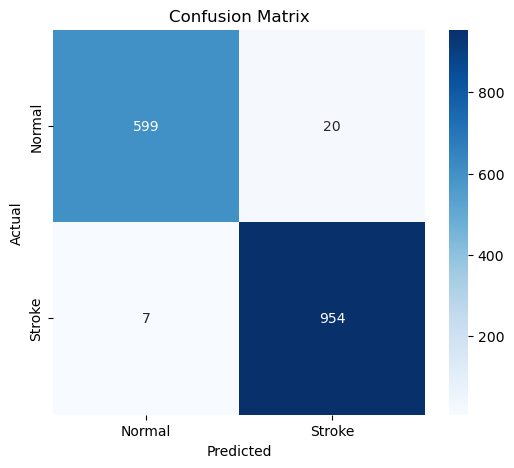


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       619
           1       0.98      0.99      0.99       961

    accuracy                           0.98      1580
   macro avg       0.98      0.98      0.98      1580
weighted avg       0.98      0.98      0.98      1580



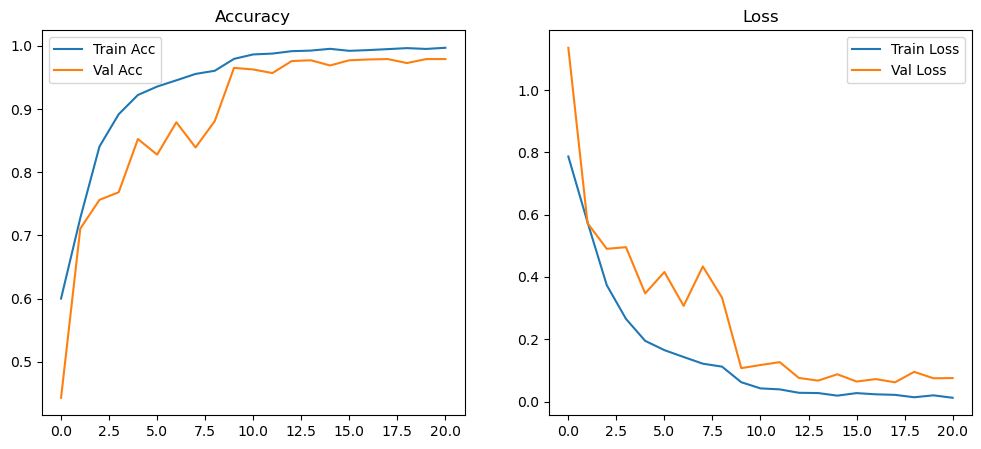

In [7]:
# ✅ STEP 6: Evaluate and visualize
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f} - Loss: {loss:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stroke'], yticklabels=['Normal', 'Stroke'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred_labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


In [8]:
# ✅ STEP 7: Save the model
model.save('stroke_model_mobilenetv2.h5')
print("✅ Model saved as stroke_model_mobilenetv2.h5")


✅ Model saved as stroke_model_mobilenetv2.h5


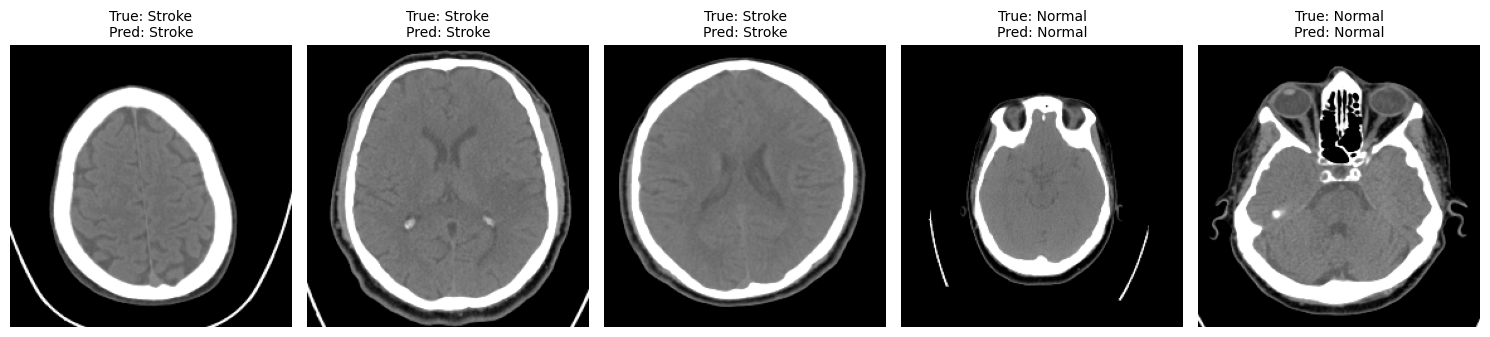

In [9]:
# ✅ STEP 8: Visualize some predictions
import random

label_map = {0: 'Normal', 1: 'Stroke'}

plt.figure(figsize=(15, 8))
for i in range(5):
    idx = random.randint(0, len(X_test)-1)
    img = X_test[idx]
    true_label = label_map[int(y_test[idx])]
    pred_label = label_map[int((y_pred[idx] >= 0.5)[0])]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_labels, digits=4)
print(report)



              precision    recall  f1-score   support

           0     0.9884    0.9677    0.9780       619
           1     0.9795    0.9927    0.9860       961

    accuracy                         0.9829      1580
   macro avg     0.9840    0.9802    0.9820      1580
weighted avg     0.9830    0.9829    0.9829      1580

